# Simulador de estrategia óptima - Modelo entrenado SOLO con Free Practices

Este notebook usa el modelo GB FE_v3 optimizado con Optuna que:
- Entrena ÚNICAMENTE con vueltas de FP1, FP2, FP3
- R2 en carrera: 0.3697
- MAE en carrera: 0.9388s
- RMSE en carrera: 1.1646s

In [33]:
# agrego reloader para no tener que cerrar y abrir vs code
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Armado del dataset de carrera para los parámetros

In [34]:
import fastf1
import pandas as pd

# 1) Activar caché
fastf1.Cache.enable_cache("cache")

# 2) Parámetros de la sesión
YEAR = 2025
GP_NAME = "Monaco"
SESSION = "R"     # 'R' = Race

session = fastf1.get_session(YEAR, GP_NAME, SESSION)
session.load()

# 3) Laps de Colapinto
laps = session.laps.pick_driver("COL").copy()

# 4) Normalizar columnas
laps["Session"] = "RACE"
laps = laps.sort_values("LapNumber").reset_index(drop=True)

print(laps[["LapNumber", "LapTime", "Compound", "TyreLife", "Stint", "TrackStatus"]].head())
print("Última vuelta:", laps["LapNumber"].max())
print("Filas:", len(laps))

# 5) Guardar CSV
laps.to_csv("data/processed/monaco_2025_colapinto_race.csv", index=False)

core           INFO 	Loading data for Monaco Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req       

   LapNumber                LapTime Compound  TyreLife  Stint TrackStatus
0        1.0 0 days 00:01:36.577000     HARD       1.0    1.0         126
1        2.0 0 days 00:01:50.894000     HARD       2.0    1.0           6
2        3.0 0 days 00:01:48.913000     HARD       3.0    1.0           6
3        4.0 0 days 00:01:36.476000     HARD       4.0    1.0         671
4        5.0 0 days 00:01:19.999000     HARD       5.0    1.0           1
Última vuelta: 76.0
Filas: 76


c:\Users\Franc\AppData\Local\Programs\Python\Python312\Lib\site-packages\fastf1\core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"


### Entrenamiento del predictor con modelo GB FE_v3 (solo prácticas)

In [35]:
import pandas as pd
import numpy as np
from src.preprocessing import add_basic_features, add_advanced_features
from src.simulator import Strategy, simulate_strategies
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# ============================================================
# 1) Cargar dataset COMPLETO (prácticas + carrera)
# ============================================================
df_all = pd.read_csv("data/processed/monaco_2025_colapinto_alllaps.csv")

# Aplicar feature engineering básico
df_fe = add_basic_features(df_all)

# Aplicar feature engineering avanzado (FE_v3)
df_fe3 = add_advanced_features(df_fe)

# Filtrar solo vueltas con pista verde (TrackStatus == 1)
if "TrackStatus" in df_fe3.columns:
    df_fe3 = df_fe3[df_fe3["TrackStatus"] == 1].copy()
    print(f"Vueltas con pista verde: {len(df_fe3)}")

print(f"Total vueltas después de FE_v3: {len(df_fe3)}")

# ============================================================
# 2) Definir features FE_v3 (las mismas que en pruebas.ipynb)
# ============================================================

LEGAL_FEATURES_NUM_V3 = [
    # Features originales
    "LapNumber",
    "Stint",
    "TyreLife",
    "lap_norm_session",
    "stint_len",
    "stint_lap_index",
    "stint_lap_norm",
    "tyrelife_norm_stint",
    "compound_order",

    # Features avanzadas
    "Lap_global",
    "track_evo",

    "S1_delta", "S2_delta", "S3_delta",
    "S1_rel", "S2_rel", "S3_rel",

    "speed_drop_fl",
    "speed_ratio_fl_st",
    "SpeedI1_norm_st",
    "SpeedI2_norm_st",

    "laps_since_pit",
    "degradation_rate",

    "compound_offset",
]

LEGAL_FEATURES_CAT_V3 = [
    "Session",
    "Compound",
]

# Filtrar solo las que existen
LEGAL_FEATURES_NUM_V3 = [c for c in LEGAL_FEATURES_NUM_V3 if c in df_fe3.columns]
LEGAL_FEATURES_CAT_V3 = [c for c in LEGAL_FEATURES_CAT_V3 if c in df_fe3.columns]

print("\nFeatures numéricas:", len(LEGAL_FEATURES_NUM_V3))
print("Features categóricas:", len(LEGAL_FEATURES_CAT_V3))

# ============================================================
# 3) Separar prácticas y carrera
# ============================================================

# ENTRENAR SOLO CON PRÁCTICAS
train_df = df_fe3[df_fe3["Session"].isin(["FP1", "FP2", "FP3"])].copy()
race_df = df_fe3[df_fe3["Session"] == "RACE"].copy()

print(f"\nVueltas de entrenamiento (prácticas): {len(train_df)}")
print(f"Vueltas de carrera: {len(race_df)}")

X_train = train_df[LEGAL_FEATURES_NUM_V3 + LEGAL_FEATURES_CAT_V3]
y_train = train_df["LapTime_s"]

# ============================================================
# 4) Crear preprocessor con imputer para manejar NaNs
# ============================================================

preprocessor_v3 = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), LEGAL_FEATURES_NUM_V3),
        ("cat", OneHotEncoder(handle_unknown="ignore"), LEGAL_FEATURES_CAT_V3),
    ]
)

# ============================================================
# 5) Entrenar modelo GB con hiperparámetros optimizados de Optuna
# ============================================================

# Hiperparámetros del mejor trial de Optuna en pruebas.ipynb
gb_fe3_optimized = GradientBoostingRegressor(
    n_estimators=790,
    learning_rate=0.006969180257057301,
    max_depth=5,
    subsample=0.8348304881167295,
    min_samples_split=4,
    min_samples_leaf=1,
    random_state=42
)

# Pipeline completo
lap_time_model = Pipeline(steps=[
    ("preprocess", preprocessor_v3),
    ("model", gb_fe3_optimized)
])

# ENTRENAR SOLO CON PRÁCTICAS
lap_time_model.fit(X_train, y_train)

print(f"\n✓ Modelo GB FE_v3 entrenado SOLO con prácticas ({len(X_train)} vueltas)")
print(f"Distribución por sesión:")
print(train_df["Session"].value_counts())
print(f"\n✓ Modelo optimizado con Optuna (R2 en carrera = 0.3697)")

# ============================================================
# 6) Cargar datos de carrera para simulación
# ============================================================
df_race = pd.read_csv("data/processed/monaco_2025_colapinto_race.csv")
df_race_fe = add_basic_features(df_race)
df_race_fe3 = add_advanced_features(df_race_fe)

print(f"\nVueltas completadas por Colapinto: {len(df_race_fe3)}")
print(f"Total de vueltas de la carrera: {session.total_laps}")
print(f"Estado: Lapped (perdió {session.total_laps - len(df_race_fe3)} vueltas)")

Vueltas con pista verde: 100
Total vueltas después de FE_v3: 100

Features numéricas: 24
Features categóricas: 2

Vueltas de entrenamiento (prácticas): 35
Vueltas de carrera: 65

✓ Modelo GB FE_v3 entrenado SOLO con prácticas (35 vueltas)
Distribución por sesión:
Session
FP2    14
FP1    12
FP3     9
Name: count, dtype: int64

✓ Modelo optimizado con Optuna (R2 en carrera = 0.3697)

Vueltas completadas por Colapinto: 76
Total de vueltas de la carrera: 78
Estado: Lapped (perdió 2 vueltas)

✓ Modelo GB FE_v3 entrenado SOLO con prácticas (35 vueltas)
Distribución por sesión:
Session
FP2    14
FP1    12
FP3     9
Name: count, dtype: int64

✓ Modelo optimizado con Optuna (R2 en carrera = 0.3697)

Vueltas completadas por Colapinto: 76
Total de vueltas de la carrera: 78
Estado: Lapped (perdió 2 vueltas)


In [36]:
# Recargar módulos para obtener los últimos cambios
import importlib
import src.preprocessing
import src.simulator
importlib.reload(src.preprocessing)
importlib.reload(src.simulator)
from src.simulator import Strategy, simulate_strategies, simulate_strategy_for_driver
from src.preprocessing import add_basic_features, add_advanced_features

print("✓ Módulos recargados")

✓ Módulos recargados


### Definir y simular estrategias

In [37]:
# Usar las 76 vueltas que completó Colapinto
total_laps = int(df_race_fe3["LapNumber"].max())
print(f"Total de vueltas para simulación: {total_laps}")

# Definir diferentes estrategias a evaluar (para 76 vueltas)
strategies = [
    Strategy("S-M-H", [("SOFT", 15), ("MEDIUM", 22), ("HARD", total_laps - 37)]),
    Strategy("M-M-H", [("MEDIUM", 20), ("MEDIUM", 20), ("HARD", total_laps - 40)]),
    Strategy("M-H", [("MEDIUM", 25), ("HARD", total_laps - 25)]),
    Strategy("H-M", [("HARD", 30), ("MEDIUM", total_laps - 30)]),
    Strategy("H-S", [("HARD", 35), ("SOFT", total_laps - 35)]),
    Strategy("S-H", [("SOFT", 20), ("HARD", total_laps - 20)]),
]

print("\nEstrategias a evaluar:")
for strat in strategies:
    print(f"  {strat.name}: {strat.stints}")

Total de vueltas para simulación: 76

Estrategias a evaluar:
  S-M-H: [('SOFT', 15), ('MEDIUM', 22), ('HARD', 39)]
  M-M-H: [('MEDIUM', 20), ('MEDIUM', 20), ('HARD', 36)]
  M-H: [('MEDIUM', 25), ('HARD', 51)]
  H-M: [('HARD', 30), ('MEDIUM', 46)]
  H-S: [('HARD', 35), ('SOFT', 41)]
  S-H: [('SOFT', 20), ('HARD', 56)]


In [38]:
# Simular todas las estrategias
standings = simulate_strategies(
    df_race_base=df_race_fe3,
    lap_time_model=lap_time_model,
    legal_features_num=LEGAL_FEATURES_NUM_V3,
    legal_features_cat=LEGAL_FEATURES_CAT_V3,
    strategies=strategies,
    pit_loss_s=20.0,  # Penalización de 20 segundos por pit stop
)

print("\n=== Clasificación de Estrategias ===" )
standings


=== Clasificación de Estrategias ===


,strategy_name,total_time_s,position,total_time_str
0,H-M,5896.850201,1,98:16.850
1,H-S,5897.244274,2,98:17.244
2,M-H,5897.330093,3,98:17.330
3,S-H,5897.571336,4,98:17.571
4,M-M-H,5917.653073,5,98:37.653
5,S-M-H,5917.802170,6,98:37.802


### Análisis detallado de la mejor estrategia

In [39]:
from src.simulator import simulate_strategy_for_driver

# Obtener la mejor estrategia
best_strategy_name = standings.iloc[0]["strategy_name"]
best_strategy = [s for s in strategies if s.name == best_strategy_name][0]

print(f"Mejor estrategia: {best_strategy_name}")
print(f"Tiempo total: {standings.iloc[0]['total_time_str']}")
print(f"\nDetalle de stints:")
for i, (compound, laps) in enumerate(best_strategy.stints, 1):
    print(f"  Stint {i}: {compound} - {laps} vueltas")

# Simular detalladamente la mejor estrategia
best_result = simulate_strategy_for_driver(
    df_race_base=df_race_fe3,
    lap_time_model=lap_time_model,
    legal_features_num=LEGAL_FEATURES_NUM_V3,
    legal_features_cat=LEGAL_FEATURES_CAT_V3,
    strategy=best_strategy,
    pit_loss_s=20.0,
)

# Mostrar las primeras vueltas de cada stint
df_best = best_result["df_sim"]
print("\n=== Tiempos por vuelta (primeras de cada stint) ===")
df_best[df_best["TyreLife"] == 1][["LapNumber", "Stint", "Compound", "LapTime_pred_s", "PitLoss_s", "LapTime_total_s"]]

Mejor estrategia: H-M
Tiempo total: 98:16.850

Detalle de stints:
  Stint 1: HARD - 30 vueltas
  Stint 2: MEDIUM - 46 vueltas

=== Tiempos por vuelta (primeras de cada stint) ===


,LapNumber,Stint,Compound,LapTime_pred_s,PitLoss_s,LapTime_total_s
0,1.0,1,HARD,80.565727,15.0,95.565727
30,31.0,2,MEDIUM,74.597399,20.0,94.597399


### Visualización de tiempos por vuelta

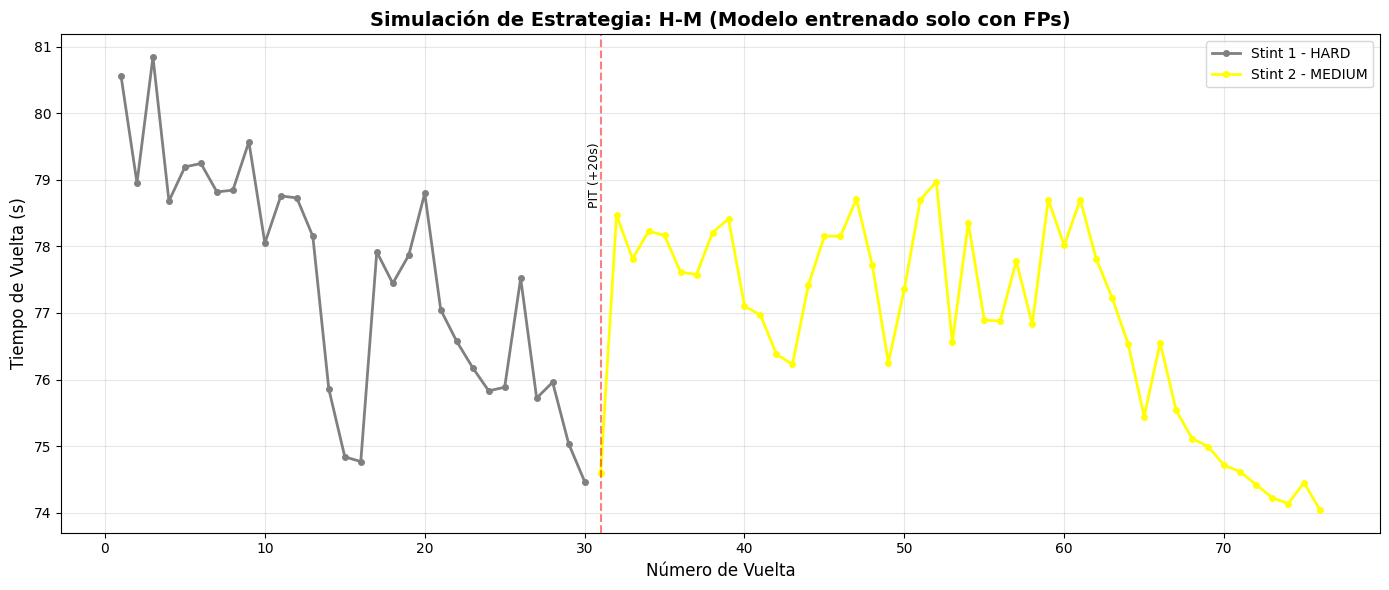


=== Resumen por Stint ===
Stint 1 (HARD): 30 vueltas - Promedio: 77.537s
Stint 2 (MEDIUM): 46 vueltas - Promedio: 76.864s


In [40]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(14, 6))

# Colores por compuesto
compound_colors = {
    "SOFT": "red",
    "MEDIUM": "yellow", 
    "HARD": "grey",
}

# Plot de tiempos predichos por vuelta
for stint in df_best["Stint"].unique():
    stint_data = df_best[df_best["Stint"] == stint]
    compound = stint_data.iloc[0]["Compound"]
    
    ax.plot(
        stint_data["LapNumber"],
        stint_data["LapTime_pred_s"],
        marker='o',
        color=compound_colors.get(compound, "gray"),
        label=f"Stint {stint} - {compound}",
        linewidth=2,
        markersize=4,
    )
    
    # Marcar pit stops
    if stint > 1:
        first_lap = stint_data.iloc[0]
        ax.axvline(x=first_lap["LapNumber"], color='red', linestyle='--', alpha=0.5)
        ax.text(first_lap["LapNumber"], ax.get_ylim()[1]*0.98, 
                f'PIT (+{first_lap["PitLoss_s"]:.0f}s)', 
                rotation=90, va='top', ha='right', fontsize=9)

ax.set_xlabel("Número de Vuelta", fontsize=12)
ax.set_ylabel("Tiempo de Vuelta (s)", fontsize=12)
ax.set_title(f"Simulación de Estrategia: {best_strategy_name} (Modelo entrenado solo con FPs)", fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Resumen de tiempos por stint
print("\n=== Resumen por Stint ===")
for stint in df_best["Stint"].unique():
    stint_data = df_best[df_best["Stint"] == stint]
    compound = stint_data.iloc[0]["Compound"]
    avg_time = stint_data["LapTime_pred_s"].mean()
    n_laps = len(stint_data)
    
    print(f"Stint {stint} ({compound}): {n_laps} vueltas - Promedio: {avg_time:.3f}s")

### Comparación entre todas las estrategias

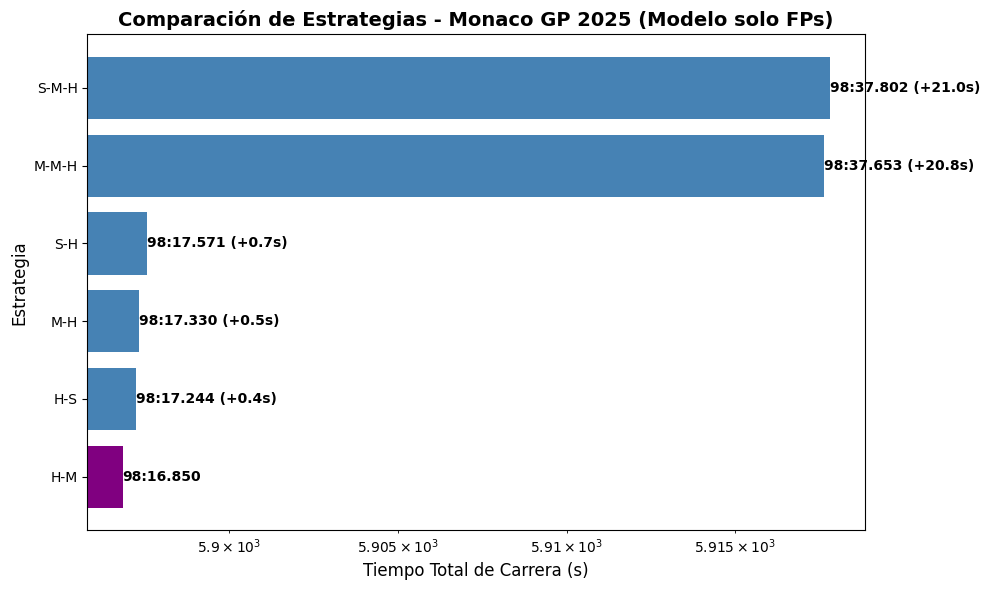


=== Tabla de Resultados ===


,position,strategy_name,total_time_str
0,1,H-M,98:16.850
1,2,H-S,98:17.244
2,3,M-H,98:17.330
3,4,S-H,98:17.571
4,5,M-M-H,98:37.653
5,6,S-M-H,98:37.802


In [41]:
fig, ax = plt.subplots(figsize=(10, 6))

# Gráfico de barras con los tiempos totales
strategies_names = standings["strategy_name"]
times_seconds = standings["total_time_s"]
positions = standings["position"]

# Diferencias con respecto al mejor
time_diff = times_seconds - times_seconds.min()

bars = ax.barh(strategies_names, times_seconds, color=['purple' if i == 0 else 'steelblue' for i in range(len(standings))])

# Añadir etiquetas con tiempo y diferencia
for i, (time, diff) in enumerate(zip(standings["total_time_str"], time_diff)):
    if diff == 0:
        label = f"{time}"
    else:
        label = f"{time} (+{diff:.1f}s)"
    ax.text(times_seconds.iloc[i], i, label, va='center', ha='left', fontsize=10, fontweight='bold')

ax.set_xlabel("Tiempo Total de Carrera (s)", fontsize=12)
ax.set_ylabel("Estrategia", fontsize=12)
ax.set_title("Comparación de Estrategias - Monaco GP 2025 (Modelo solo FPs)", fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
ax.set_xscale('log')

plt.tight_layout()
plt.show()

print("\n=== Tabla de Resultados ===")
standings[["position", "strategy_name", "total_time_str"]]

### Comparación con estrategia real de Colapinto

In [42]:
# Extraer la estrategia real usada por Colapinto en la carrera
df_race_real = pd.read_csv("data/processed/monaco_2025_colapinto_race.csv")

# Obtener información de los stints reales
stints_info = []
for stint in sorted(df_race_real["Stint"].unique()):
    stint_data = df_race_real[df_race_real["Stint"] == stint]
    compound = stint_data.iloc[0]["Compound"]
    n_laps = len(stint_data)
    stints_info.append((compound, n_laps))

# Crear estrategia real
real_strategy = Strategy("REAL", stints_info)

print("=== Estrategia Real de Colapinto ===")
print(f"Estrategia: {real_strategy.name}")
for i, (compound, laps) in enumerate(real_strategy.stints, 1):
    print(f"  Stint {i}: {compound} - {laps} vueltas")

# Preparar datos de carrera con FE_v3
df_race_real_fe = add_basic_features(df_race_real)
df_race_real_fe3 = add_advanced_features(df_race_real_fe)

# Simular la estrategia real
real_result = simulate_strategy_for_driver(
    df_race_base=df_race_real_fe3,
    lap_time_model=lap_time_model,
    legal_features_num=LEGAL_FEATURES_NUM_V3,
    legal_features_cat=LEGAL_FEATURES_CAT_V3,
    strategy=real_strategy,
    pit_loss_s=20.0,
)

print(f"\nTiempo simulado con estrategia real: {real_result['total_time_s']:.3f}s")

# Comparar con la mejor estrategia
best_time_s = standings.iloc[0]['total_time_s']
time_diff = real_result['total_time_s'] - best_time_s
print(f"Mejor estrategia: {standings.iloc[0]['strategy_name']} - {best_time_s:.3f}s")
print(f"Diferencia con mejor estrategia: {'+' if time_diff > 0 else ''}{time_diff:.3f}s")
print(f"Mejora potencial: {abs(time_diff):.3f}s")

=== Estrategia Real de Colapinto ===
Estrategia: REAL
  Stint 1: HARD - 13 vueltas
  Stint 2: MEDIUM - 13 vueltas
  Stint 3: MEDIUM - 50 vueltas

Tiempo simulado con estrategia real: 5916.102s
Mejor estrategia: H-M - 5896.850s
Diferencia con mejor estrategia: +19.252s
Mejora potencial: 19.252s


### Clasificación completa F1 con comparación de estrategias

In [43]:
# Obtener resultados completos de la carrera
race_results = session.results

# Crear DataFrame con clasificación real
leaderboard = pd.DataFrame({
    "Position": race_results["Position"],
    "Driver": race_results["Abbreviation"],
    "Team": race_results["TeamName"],
    "Time": race_results["Time"],
    "Status": race_results["Status"],
})

# Convertir tiempo a segundos para comparaciones
# IMPORTANTE: Los tiempos en F1 son GAPS respecto al ganador (excepto el ganador que tiene tiempo absoluto)
def time_to_seconds(time_val):
    if pd.isna(time_val) or time_val == "":
        return None
    try:
        time_td = pd.to_timedelta(time_val)
        return time_td.total_seconds()
    except:
        return None

leaderboard["Gap_s"] = leaderboard["Time"].apply(time_to_seconds)

# El ganador (P1) tiene el tiempo absoluto, los demás tienen gap
winner = leaderboard[leaderboard["Position"] == 1].iloc[0]
winner_time_s = winner["Gap_s"]  # Este es el tiempo absoluto del ganador

print(f"=== Ganador de la Carrera ===")
print(f"Piloto: {winner['Driver']}")
print(f"Tiempo total: {winner['Time']}")

# Calcular tiempos absolutos para todos
leaderboard["Time_s"] = leaderboard.apply(
    lambda row: winner_time_s if row["Position"] == 1 else (winner_time_s + row["Gap_s"] if row["Gap_s"] else None),
    axis=1
)

# Obtener posición y tiempo real de Colapinto
colapinto_real = leaderboard[leaderboard["Driver"] == "COL"].iloc[0]
colapinto_position = int(colapinto_real["Position"])
colapinto_time_s = colapinto_real["Time_s"]
colapinto_gap_s = colapinto_real["Gap_s"]

print(f"\n=== Posición Real de Colapinto ===")
print(f"Posición: P{colapinto_position}")
print(f"Gap con ganador: {colapinto_real['Time']}")
print(f"Tiempo absoluto estimado: {colapinto_time_s:.3f}s")
print(f"Estado: {colapinto_real['Status']}")

# Calcular tiempo con mejor estrategia
best_time_s = standings.iloc[0]['total_time_s']

print(f"\nVueltas de carrera para simulación: {len(df_race_fe3)}")
print(f"Última vuelta de carrera: {df_race_fe3['LapNumber'].max()}")

=== Ganador de la Carrera ===
Piloto: NOR
Tiempo total: 0 days 01:40:33.843000

=== Posición Real de Colapinto ===
Posición: P13
Gap con ganador: 0 days 00:00:57.114000
Tiempo absoluto estimado: 6090.957s
Estado: Lapped

Vueltas de carrera para simulación: 76
Última vuelta de carrera: 76.0


In [44]:
# Crear leaderboard con Colapinto real y con mejor estrategia
leaderboard_extended = leaderboard.copy()

# Calcular tiempo hipotético de Colapinto con mejor estrategia
time_saved = real_result['total_time_s'] - best_time_s

print(f"\n=== Análisis de Colapinto - Estado: Lapped ===")
print(f"Vueltas completadas: 76 (perdió 2 vueltas)")
print(f"Tiempo simulado con estrategia real (76v): {real_result['total_time_s']:.3f}s")
print(f"Tiempo simulado con mejor estrategia (76v): {best_time_s:.3f}s")
print(f"Tiempo que habría ahorrado: {time_saved:.3f}s")

# Agregar fila de Colapinto con mejor estrategia
colapinto_best = {
    "Position": None,
    "Driver": "COL*",
    "Team": colapinto_real["Team"],
    "Time": None,
    "Time_s": best_time_s,
    "Status": "Lapped",
    "Laps_completed": 76
}

# Convertir a lista
leaderboard_list = leaderboard_extended.to_dict('records')

# Calcular vueltas completadas para cada piloto
# Los que tienen "Lapped" en el status perdieron vueltas, pero pueden ser diferentes cantidades
total_race_laps = session.total_laps

for record in leaderboard_list:
    if record["Status"] == "Finished":
        record["Laps_completed"] = total_race_laps
    elif record["Status"] == "Lapped":
        # Obtener las vueltas del piloto desde FastF1
        driver_laps = session.laps.pick_driver(record["Driver"])
        if len(driver_laps) > 0:
            record["Laps_completed"] = int(driver_laps["LapNumber"].max())
        else:
            record["Laps_completed"] = 0
    else:  # DNF, Retired, etc.
        driver_laps = session.laps.pick_driver(record["Driver"])
        if len(driver_laps) > 0:
            record["Laps_completed"] = int(driver_laps["LapNumber"].max())
        else:
            record["Laps_completed"] = 0

leaderboard_list.append(colapinto_best)

# Crear DataFrame
leaderboard_comparison = pd.DataFrame(leaderboard_list)

# Ordenar: primero por vueltas completadas (desc), luego por tiempo (asc)
leaderboard_comparison = leaderboard_comparison.sort_values(
    by=["Laps_completed", "Time_s"],
    ascending=[False, True]
).reset_index(drop=True)

# Asignar nuevas posiciones
leaderboard_comparison["New_Position"] = range(1, len(leaderboard_comparison) + 1)

# Formatear tiempos para display
winner_time_final = leaderboard_comparison.iloc[0]["Time_s"]

for idx, row in leaderboard_comparison.iterrows():
    if pd.isna(row["Time_s"]) or row["Time_s"] is None:
        leaderboard_comparison.at[idx, "Time_Display"] = "DNF"
    elif row["Laps_completed"] < total_race_laps:
        # Mostrar cuántas vueltas perdió
        laps_down = total_race_laps - row["Laps_completed"]
        if laps_down == 1:
            leaderboard_comparison.at[idx, "Time_Display"] = "1 LAP"
        else:
            leaderboard_comparison.at[idx, "Time_Display"] = f"{int(laps_down)} LAPS"
    elif idx == 0:
        # El ganador muestra su tiempo total
        time_val = row["Time_s"]
        minutes = int(time_val // 60)
        seconds = time_val % 60
        leaderboard_comparison.at[idx, "Time_Display"] = f"{minutes:02d}:{seconds:06.3f}"
    else:
        # Los que completaron todas las vueltas muestran gap con el ganador
        gap = row["Time_s"] - winner_time_final
        minutes = int(gap // 60)
        seconds = gap % 60
        leaderboard_comparison.at[idx, "Time_Display"] = f"+{minutes:02d}:{seconds:06.3f}"

# Mostrar tabla comparativa
print("\n=== CLASIFICACIÓN FINAL - MONACO GP 2025 (Modelo solo FPs) ===")
print("(COL* = Colapinto con mejor estrategia simulada - mismas 76 vueltas)\n")

display_cols = ["New_Position", "Driver", "Team", "Time_Display", "Status", "Laps_completed"]
leaderboard_display = leaderboard_comparison[display_cols].copy()
leaderboard_display.columns = ["Pos", "Driver", "Team", "Time/Gap", "Status", "Laps"]

print(leaderboard_display.to_string(index=False))

# Resumen de cambios
colapinto_real_pos = leaderboard_comparison[leaderboard_comparison["Driver"] == "COL"]["New_Position"].values[0]
colapinto_sim_pos = leaderboard_comparison[leaderboard_comparison["Driver"] == "COL*"]["New_Position"].values[0]
position_gain = colapinto_real_pos - colapinto_sim_pos

print(f"\n=== RESUMEN ===")
print(f"Posición real de Colapinto: P{colapinto_real_pos} (76 vueltas)")
print(f"Posición con mejor estrategia: P{colapinto_sim_pos} (76 vueltas)")
if position_gain > 0:
    print(f"✓ Ganancia potencial: {position_gain} {'posición' if position_gain == 1 else 'posiciones'}")
    print(f"✓ Tiempo ahorrado: {time_saved:.3f}s ({time_saved/76:.3f}s por vuelta)")
elif position_gain < 0:
    print(f"✗ Pérdida: {abs(position_gain)} {'posición' if abs(position_gain) == 1 else 'posiciones'}")
else:
    print(f"Sin cambio de posición, pero {time_saved:.3f}s más rápido")


=== Análisis de Colapinto - Estado: Lapped ===
Vueltas completadas: 76 (perdió 2 vueltas)
Tiempo simulado con estrategia real (76v): 5916.102s
Tiempo simulado con mejor estrategia (76v): 5896.850s
Tiempo que habría ahorrado: 19.252s

=== CLASIFICACIÓN FINAL - MONACO GP 2025 (Modelo solo FPs) ===
(COL* = Colapinto con mejor estrategia simulada - mismas 76 vueltas)

 Pos Driver            Team   Time/Gap   Status  Laps
   1    NOR         McLaren 100:33.843 Finished    78
   2    LEC         Ferrari +00:03.131 Finished    78
   3    PIA         McLaren +00:03.658 Finished    78
   4    VER Red Bull Racing +00:20.572 Finished    78
   5    HAM         Ferrari +00:51.387 Finished    78
   6    HAD    Racing Bulls      1 LAP   Lapped    77
   7    OCO    Haas F1 Team      1 LAP   Lapped    77
   8    LAW    Racing Bulls      1 LAP   Lapped    77
   9   COL*          Alpine     2 LAPS   Lapped    76
  10    ALB        Williams     2 LAPS   Lapped    76
  11    SAI        Williams     2 LAPS

c:\Users\Franc\AppData\Local\Programs\Python\Python312\Lib\site-packages\fastf1\core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"


### Visualización de la clasificación con ambas estrategias

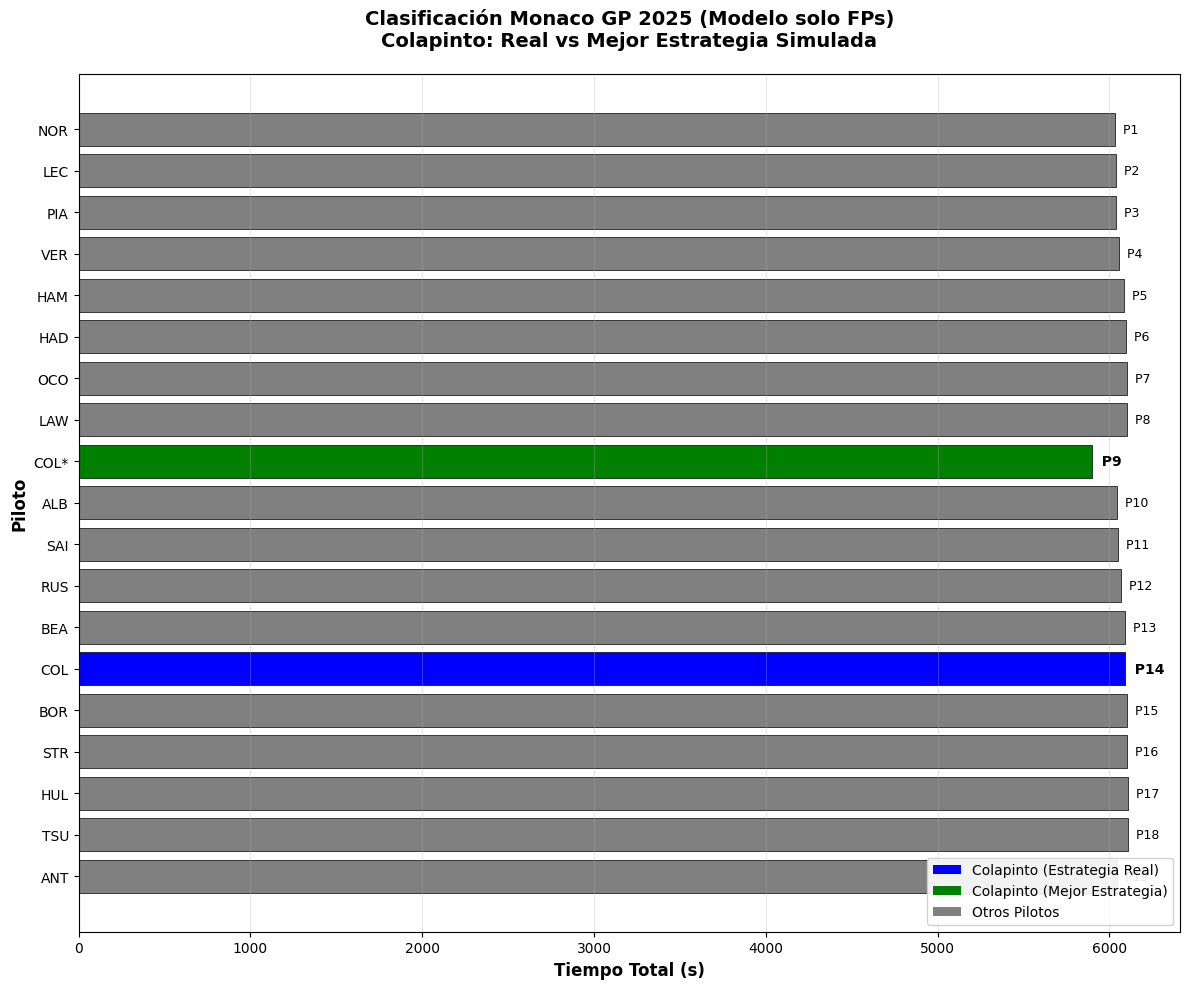

In [45]:
fig, ax = plt.subplots(figsize=(12, 10))

# Filtrar solo los que tienen tiempo válido
leaderboard_plot = leaderboard_comparison[leaderboard_comparison["Time_s"].notna()].copy()

# Colores: resaltar a Colapinto
colors = []
for driver in leaderboard_plot["Driver"]:
    if driver == "COL":
        colors.append("blue")  # Azul para real
    elif driver == "COL*":
        colors.append("green")  # Verde para simulado
    else:
        colors.append("gray")  # Gris para resto

# Gráfico horizontal
bars = ax.barh(
    leaderboard_plot["Driver"],
    leaderboard_plot["Time_s"],
    color=colors,
    edgecolor='black',
    linewidth=0.5
)

# Añadir etiquetas de posición
for idx, row in leaderboard_plot.iterrows():
    pos = row["New_Position"]
    time = row["Time_s"]
    driver = row["Driver"]
    
    # Etiqueta de posición
    label = f"P{int(pos)}"
    if driver in ["COL", "COL*"]:
        fontweight = 'bold'
        fontsize = 10
    else:
        fontweight = 'normal'
        fontsize = 9
    
    ax.text(time, driver, f"  {label}", va='center', ha='left', 
            fontsize=fontsize, fontweight=fontweight)

ax.set_xlabel("Tiempo Total (s)", fontsize=12, fontweight='bold')
ax.set_ylabel("Piloto", fontsize=12, fontweight='bold')
ax.set_title("Clasificación Monaco GP 2025 (Modelo solo FPs)\nColapinto: Real vs Mejor Estrategia Simulada", 
             fontsize=14, fontweight='bold', pad=20)

# Leyenda
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='blue', label='Colapinto (Estrategia Real)'),
    Patch(facecolor='green', label='Colapinto (Mejor Estrategia)'),
    Patch(facecolor='gray', label='Otros Pilotos')
]
ax.legend(handles=legend_elements, loc='lower right', framealpha=0.9)

ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()  # Primer lugar arriba

plt.tight_layout()
plt.show()

### Calcular tiempos totales reales sumando tiempos de vuelta

In [46]:
# Calcular tiempos totales REALES sumando los tiempos de cada vuelta
all_drivers = session.results["Abbreviation"].values

real_times = {}

for driver_abbr in all_drivers:
    driver_laps = session.laps.pick_driver(driver_abbr)
    
    if len(driver_laps) == 0:
        real_times[driver_abbr] = {
            "total_time_s": None,
            "laps_completed": 0,
            "status": "DNF"
        }
        continue
    
    # Sumar todos los tiempos de vuelta
    lap_times_s = driver_laps["LapTime"].dt.total_seconds()
    total_time_s = lap_times_s.sum()
    laps_completed = int(driver_laps["LapNumber"].max())
    
    # Obtener status
    driver_result = session.results[session.results["Abbreviation"] == driver_abbr]
    status = driver_result["Status"].values[0] if len(driver_result) > 0 else "Unknown"
    
    real_times[driver_abbr] = {
        "total_time_s": total_time_s,
        "laps_completed": laps_completed,
        "status": status
    }

# Crear DataFrame con tiempos reales calculados
real_times_df = pd.DataFrame([
    {
        "Driver": driver,
        "Total_Time_s": data["total_time_s"],
        "Laps_Completed": data["laps_completed"],
        "Status": data["status"]
    }
    for driver, data in real_times.items()
])

print("=== TIEMPOS TOTALES REALES (suma de tiempos de vuelta) ===\n")
print(real_times_df.sort_values(["Laps_Completed", "Total_Time_s"], ascending=[False, True]).to_string(index=False))

# Comparar con Colapinto
colapinto_real_time = real_times["COL"]["total_time_s"]
colapinto_laps = real_times["COL"]["laps_completed"]

print(f"\n=== COLAPINTO - TIEMPOS REALES vs SIMULADOS ===")
print(f"Tiempo real (suma de vueltas): {colapinto_real_time:.3f}s ({colapinto_laps} vueltas)")
print(f"Tiempo simulado estrategia real: {real_result['total_time_s']:.3f}s (76 vueltas)")
print(f"Tiempo simulado mejor estrategia: {best_time_s:.3f}s (76 vueltas)")
print(f"\nDiferencia simulación vs realidad: {abs(real_result['total_time_s'] - colapinto_real_time):.3f}s")
print(f"Mejora potencial (simulada): {abs(real_result['total_time_s'] - best_time_s):.3f}s")

=== TIEMPOS TOTALES REALES (suma de tiempos de vuelta) ===

Driver  Total_Time_s  Laps_Completed   Status
   NOR      6033.843              78 Finished
   LEC      6036.974              78 Finished
   PIA      6037.501              78 Finished
   VER      6054.415              78 Finished
   HAM      6085.230              78 Finished
   HAD      6098.925              77   Lapped
   OCO      6099.872              77   Lapped
   LAW      6100.589              77   Lapped
   ALB      6045.712              76   Lapped
   SAI      6049.075              76   Lapped
   RUS      6067.687              76   Lapped
   BEA      6088.536              76   Lapped
   COL      6090.957              76   Lapped
   BOR      6102.267              76   Lapped
   STR      6104.238              76   Lapped
   HUL      6105.387              76   Lapped
   TSU      6105.692              76   Lapped
   ANT      6042.252              75   Lapped
   ALO      2907.102              37  Retired
   GAS       657.609

c:\Users\Franc\AppData\Local\Programs\Python\Python312\Lib\site-packages\fastf1\core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"


### Comparación visual: Óptima vs Real Simulada vs Real

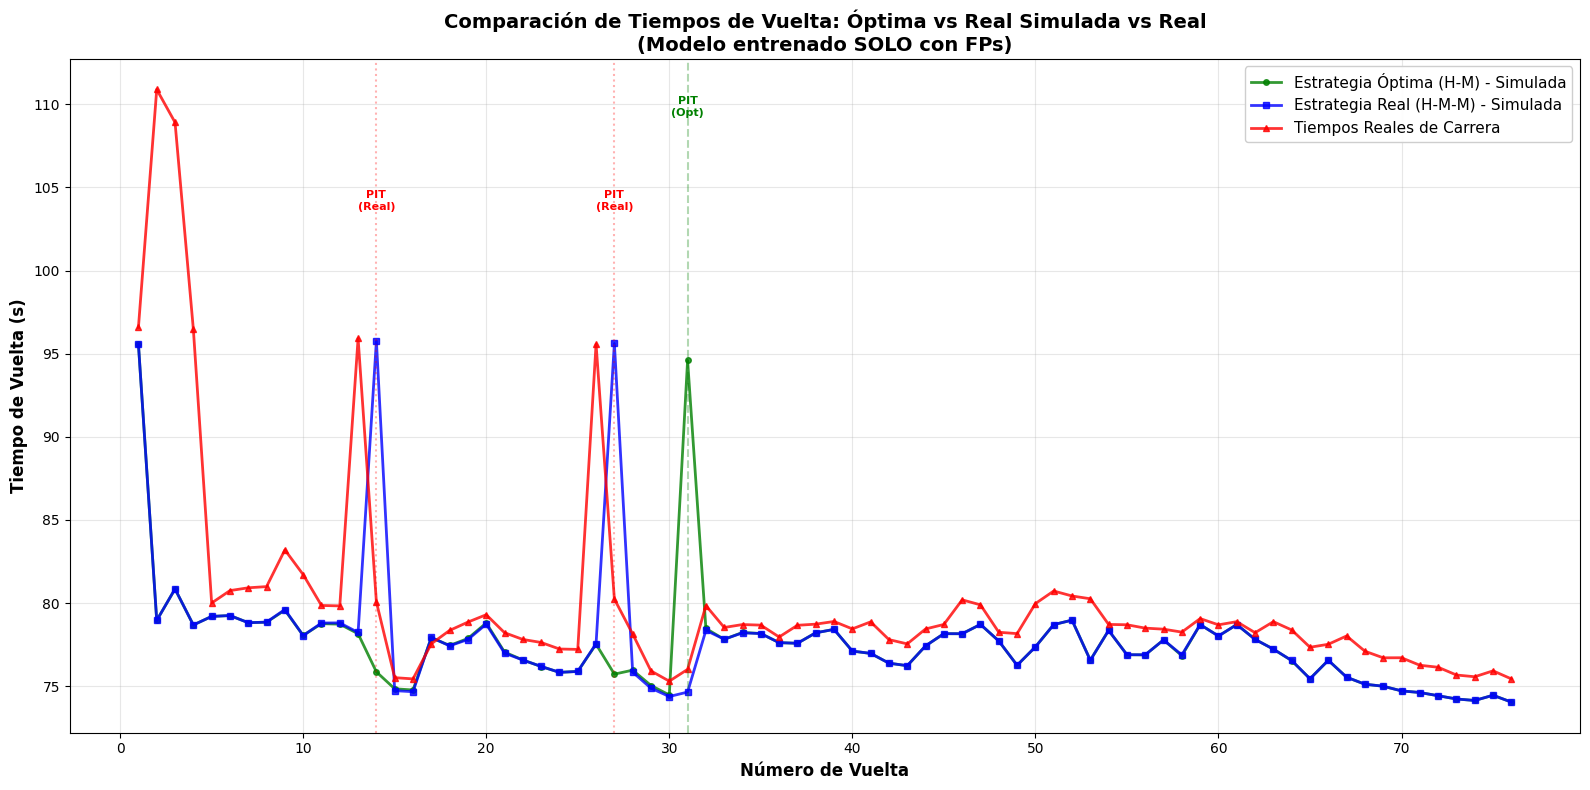


ANÁLISIS COMPARATIVO - 76 VUELTAS (Modelo solo FPs)

1. TIEMPOS TOTALES:
   Estrategia Óptima (H-M):      5896.850s
   Estrategia Real Simulada:     5916.102s
   Tiempos Reales de Carrera:    6090.957s

2. DIFERENCIAS:
   Óptima vs Real Simulada:      19.252s (0.253s/vuelta)
   Óptima vs Real Actual:        194.107s (2.554s/vuelta)
   Real Simulada vs Real Actual: 174.855s (2.301s/vuelta)

3. TIEMPOS MEDIOS POR VUELTA:
   Estrategia Óptima:            77.590s
   Estrategia Real Simulada:     77.843s
   Tiempos Reales:               80.144s

4. MEJORA POTENCIAL:
   Por cambio de estrategia (modelo):  19.252s
   Considerando sesgo del modelo:      ~174.855s

NOTA: Este modelo fue entrenado SOLO con datos de prácticas (FP1, FP2, FP3)
R2 en carrera: 0.3697 | MAE: 0.9388s | RMSE: 1.1646s


In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Obtener datos de las tres versiones
# 1. Estrategia óptima
df_optimal = best_result["df_sim"].copy()
df_optimal = df_optimal.sort_values("LapNumber")

# 2. Estrategia real simulada
df_real_sim = real_result["df_sim"].copy()
df_real_sim = df_real_sim.sort_values("LapNumber")

# 3. Tiempos reales de carrera
df_real_actual = pd.read_csv("data/processed/monaco_2025_colapinto_race.csv")
df_real_actual["LapTime_s"] = pd.to_timedelta(df_real_actual["LapTime"]).dt.total_seconds()
df_real_actual = df_real_actual.sort_values("LapNumber")

# Crear figura
fig, ax = plt.subplots(figsize=(16, 8))

# Tiempos de vuelta comparativos (incluyendo penalización de pit stops)
ax.plot(
    df_optimal["LapNumber"],
    df_optimal["LapTime_total_s"],
    marker='o',
    color='green',
    label=f'Estrategia Óptima ({best_strategy_name}) - Simulada',
    linewidth=2,
    markersize=4,
    alpha=0.8
)

ax.plot(
    df_real_sim["LapNumber"],
    df_real_sim["LapTime_total_s"],
    marker='s',
    color='blue',
    label='Estrategia Real (H-M-M) - Simulada',
    linewidth=2,
    markersize=4,
    alpha=0.8
)

ax.plot(
    df_real_actual["LapNumber"],
    df_real_actual["LapTime_s"],
    marker='^',
    color='red',
    label='Tiempos Reales de Carrera',
    linewidth=2,
    markersize=4,
    alpha=0.8
)

# Marcar pit stops de estrategia óptima
for stint in df_optimal["Stint"].unique():
    if stint > 1:
        first_lap_stint = df_optimal[df_optimal["Stint"] == stint].iloc[0]
        ax.axvline(x=first_lap_stint["LapNumber"], color='green', 
                   linestyle='--', alpha=0.3, linewidth=1.5)
        ax.text(first_lap_stint["LapNumber"], ax.get_ylim()[1]*0.98,
                f'PIT\n(Opt)', rotation=0, va='top', ha='center', 
                fontsize=8, color='green', fontweight='bold')

# Marcar pit stops de estrategia real
for stint in df_real_actual["Stint"].unique():
    if stint > 1:
        first_lap_stint = df_real_actual[df_real_actual["Stint"] == stint].iloc[0]
        ax.axvline(x=first_lap_stint["LapNumber"], color='red', 
                   linestyle=':', alpha=0.3, linewidth=1.5)
        ax.text(first_lap_stint["LapNumber"], ax.get_ylim()[1]*0.93,
                f'PIT\n(Real)', rotation=0, va='top', ha='center', 
                fontsize=8, color='red', fontweight='bold')

ax.set_xlabel("Número de Vuelta", fontsize=12, fontweight='bold')
ax.set_ylabel("Tiempo de Vuelta (s)", fontsize=12, fontweight='bold')
ax.set_title("Comparación de Tiempos de Vuelta: Óptima vs Real Simulada vs Real\n(Modelo entrenado SOLO con FPs)", 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=11, framealpha=0.95)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calcular tiempos acumulados para estadísticas
cumulative_optimal = df_optimal["LapTime_total_s"].cumsum()
cumulative_real_sim = df_real_sim["LapTime_total_s"].cumsum()
cumulative_real_actual = df_real_actual["LapTime_s"].cumsum()

# Diferencias acumuladas (respecto a la óptima)
diff_real_sim = cumulative_real_sim.values - cumulative_optimal.values
diff_real_actual = cumulative_real_actual.values - cumulative_optimal.values

# ESTADÍSTICAS COMPARATIVAS
print("\n" + "="*70)
print("ANÁLISIS COMPARATIVO - 76 VUELTAS (Modelo solo FPs)")
print("="*70)

print("\n1. TIEMPOS TOTALES:")
print(f"   Estrategia Óptima ({best_strategy_name}):      {cumulative_optimal.iloc[-1]:.3f}s")
print(f"   Estrategia Real Simulada:     {cumulative_real_sim.iloc[-1]:.3f}s")
print(f"   Tiempos Reales de Carrera:    {cumulative_real_actual.iloc[-1]:.3f}s")

print("\n2. DIFERENCIAS:")
print(f"   Óptima vs Real Simulada:      {diff_real_sim[-1]:.3f}s ({diff_real_sim[-1]/76:.3f}s/vuelta)")
print(f"   Óptima vs Real Actual:        {diff_real_actual[-1]:.3f}s ({diff_real_actual[-1]/76:.3f}s/vuelta)")
print(f"   Real Simulada vs Real Actual: {diff_real_actual[-1] - diff_real_sim[-1]:.3f}s ({(diff_real_actual[-1] - diff_real_sim[-1])/76:.3f}s/vuelta)")

print("\n3. TIEMPOS MEDIOS POR VUELTA:")
print(f"   Estrategia Óptima:            {df_optimal['LapTime_total_s'].mean():.3f}s")
print(f"   Estrategia Real Simulada:     {df_real_sim['LapTime_total_s'].mean():.3f}s")
print(f"   Tiempos Reales:               {df_real_actual['LapTime_s'].mean():.3f}s")

print("\n4. MEJORA POTENCIAL:")
print(f"   Por cambio de estrategia (modelo):  {diff_real_sim[-1]:.3f}s")
print(f"   Considerando sesgo del modelo:      ~{diff_real_actual[-1] - diff_real_sim[-1]:.3f}s")

print("\n" + "="*70)
print("NOTA: Este modelo fue entrenado SOLO con datos de prácticas (FP1, FP2, FP3)")
print("R2 en carrera: 0.3697 | MAE: 0.9388s | RMSE: 1.1646s")
print("="*70)